# Malware Names

Dealing with malware names...

Starting by filtering only the selected vendors, then understanding the unique number of names per vendor.

In [1]:
from IPython.display import display
from leven import levenshtein
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import re
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

data_folder = 'data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
vendors_selected_file = data_folder + 'vendors_selected.csv.gz'
vendors_selected_filtered_file = data_folder + 'vendors_selected_filtered.csv.gz'
selected_vendors = ["Rising", "NANO-Antivirus", "Microsoft", "VBA32",
                    "TrendMicro", "Comodo", "AhnLab-V3", "Panda",
                    "Malwarebytes", "K7GW", "K7AntiVirus", "Symantec",
                    "MicroWorld-eScan", "F-Secure", "Ikarus", "DrWeb",
                    "Emsisoft", "Fortinet", "TrendMicro-HouseCall", "Avast",
                    "BitDefender", "AVG", "Kaspersky", "GData", "VIPRE",
                    "Sophos", "McAfee", "McAfee-GW-Edition", "ESET-NOD32"]

In [2]:
# Filter down vendors
# vendors = pd.read_csv(vendors_file, dtype=str)
# vendors = vendors.set_index('link')
# vendors = vendors[selected_vendors]
# vendors.to_csv(vendors_selected_file, compression='gzip')
vendors = pd.read_csv(vendors_selected_file, dtype=str)
vendors = vendors.set_index('link')
vendors.replace('Clean', np.nan, inplace=True)

In [3]:
unique_names = dict()
names_count = dict()
for vendor in vendors:
    unique_names[vendor] = vendors[vendor].dropna().unique()
    names_count[vendor] = len(vendors[vendor].dropna().unique())
    
names_count = pd.Series(names_count)

Graph showing the unique number of names per vendor:

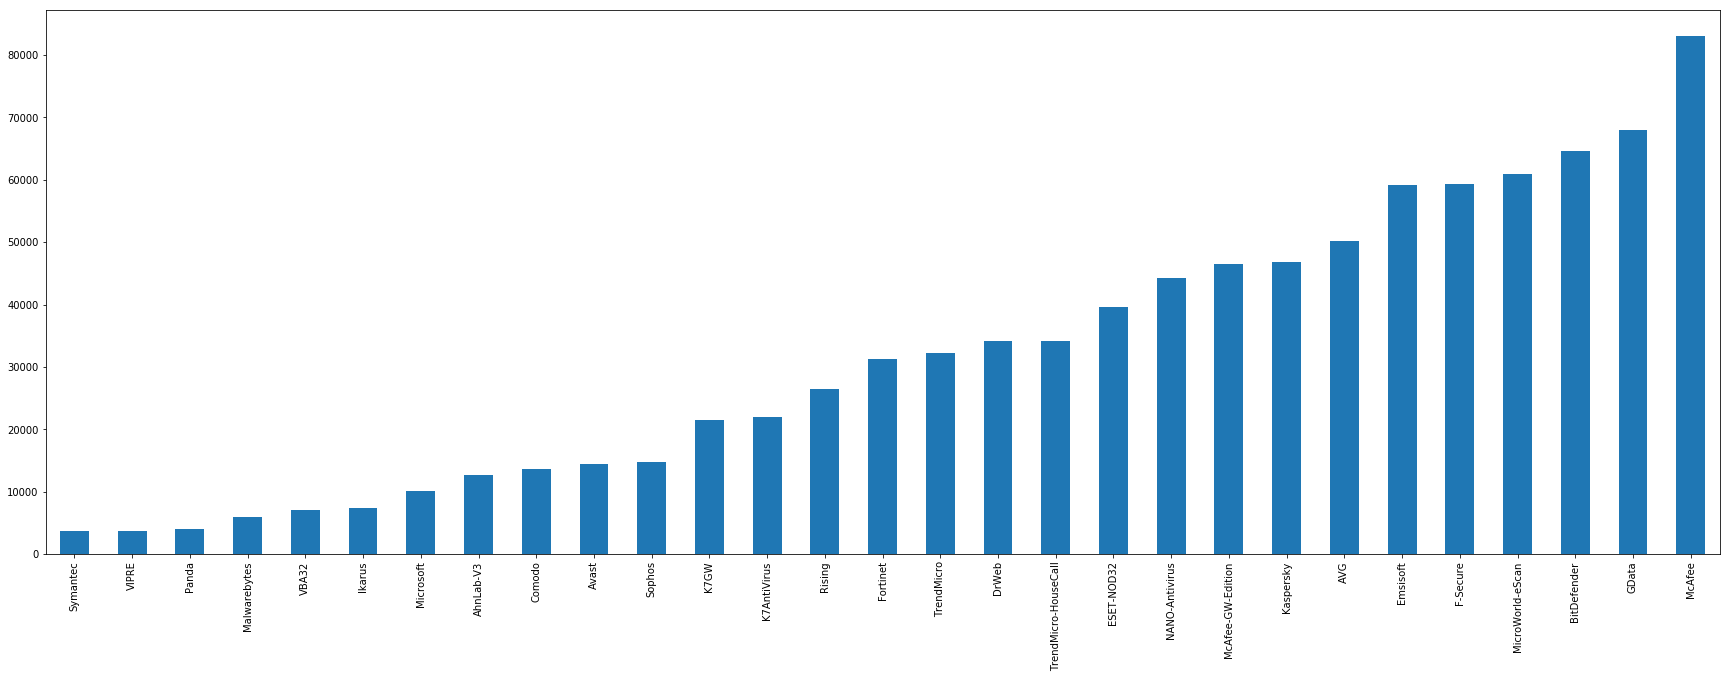

In [4]:
names_count.sort_values().plot.bar(figsize=((30, 10)))
plt.show()

## Understanding names

We want to split the malware into various levels and classes.

The highest level should be the propagation type: Virus, Worm, Trojan.

Bellow propagation type comes malware purpose and/or family.

### First Filterting

An inicial idea is to remove keywords below a given threshold, < 2 chars long. Keywords with 2 chars may still be relevant, like 'PE', 'BD', etc.

From len 2 strings, remove those with numbers. From all other, remove those that are hex values.

In [5]:
regex = re.compile(r'\W')
# Remove pairs that contain at least a number
regex2= re.compile(r'^\S\d|\d\S$')
# Remove hex values
regex3= re.compile(r'^[A-Fa-f0-9]{3,}$')

unique_keywords = dict()
filtered_names = dict()

for vendor in unique_names.keys():
    unique_keywords[vendor] = list()
    filtered_names[vendor] = set()
    for name in unique_names[vendor]:
        name = regex.split(name)
        unique_keywords[vendor] += name
        name = list(filter(lambda x: len(x) > 1 and not regex2.search(x) and not regex3.search(x), name))
        filtered_names[vendor].update(['.'.join(name).lower()])

In [6]:
before = 0
after = 0
display('Filtered names:')
for vendor in filtered_names.keys():
    before += len(unique_names[vendor])
    after += len(filtered_names[vendor])
    # display('{} {}/{}'.format(vendor, len(filtered_names[vendor]), len(unique_names[vendor])))
display('Total: {}/{}'.format(after, before))

'Filtered names:'

'Total: 413947/921603'

Graph showing the number of filtered names per vendor, followed by graph with comparison of both

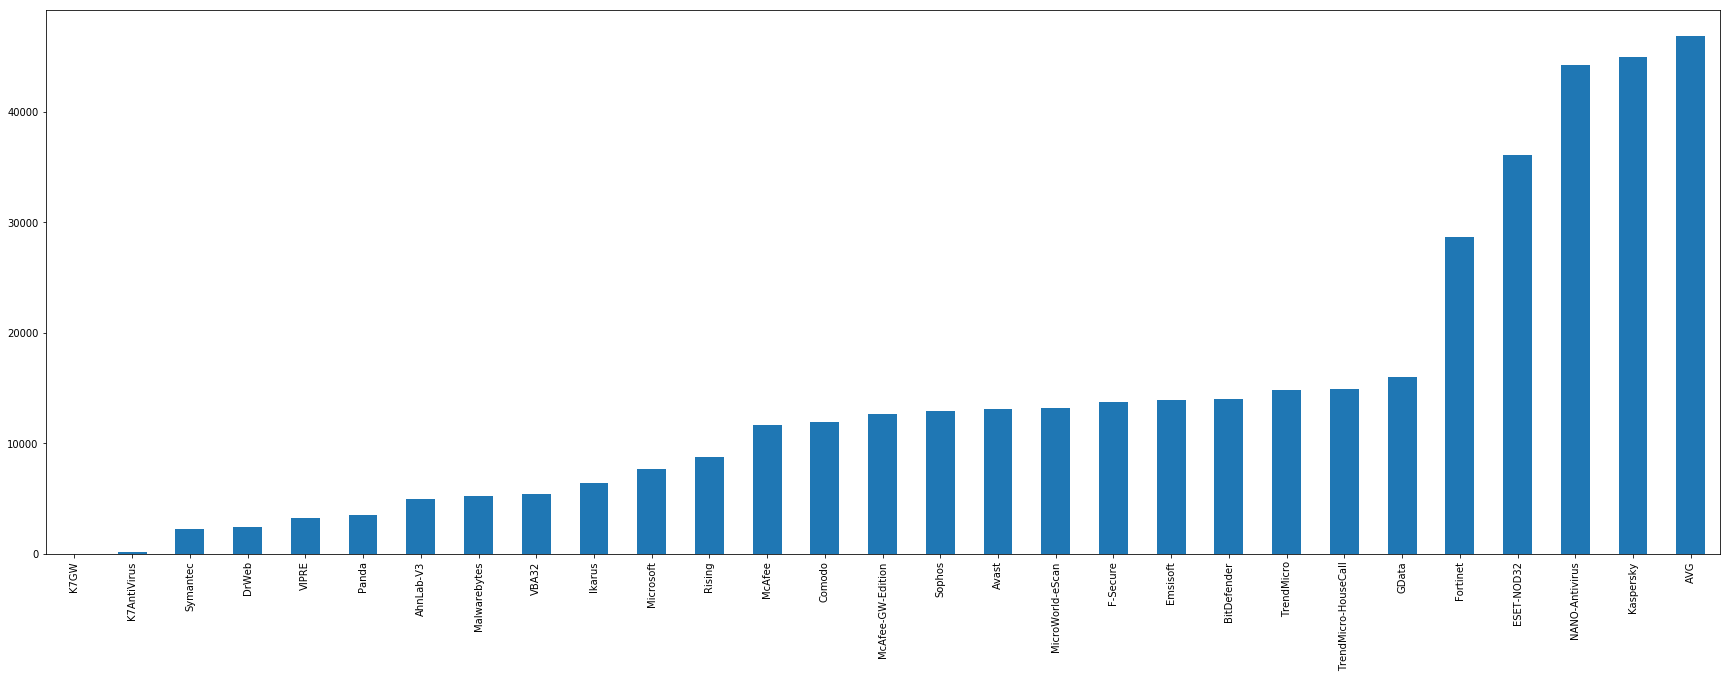

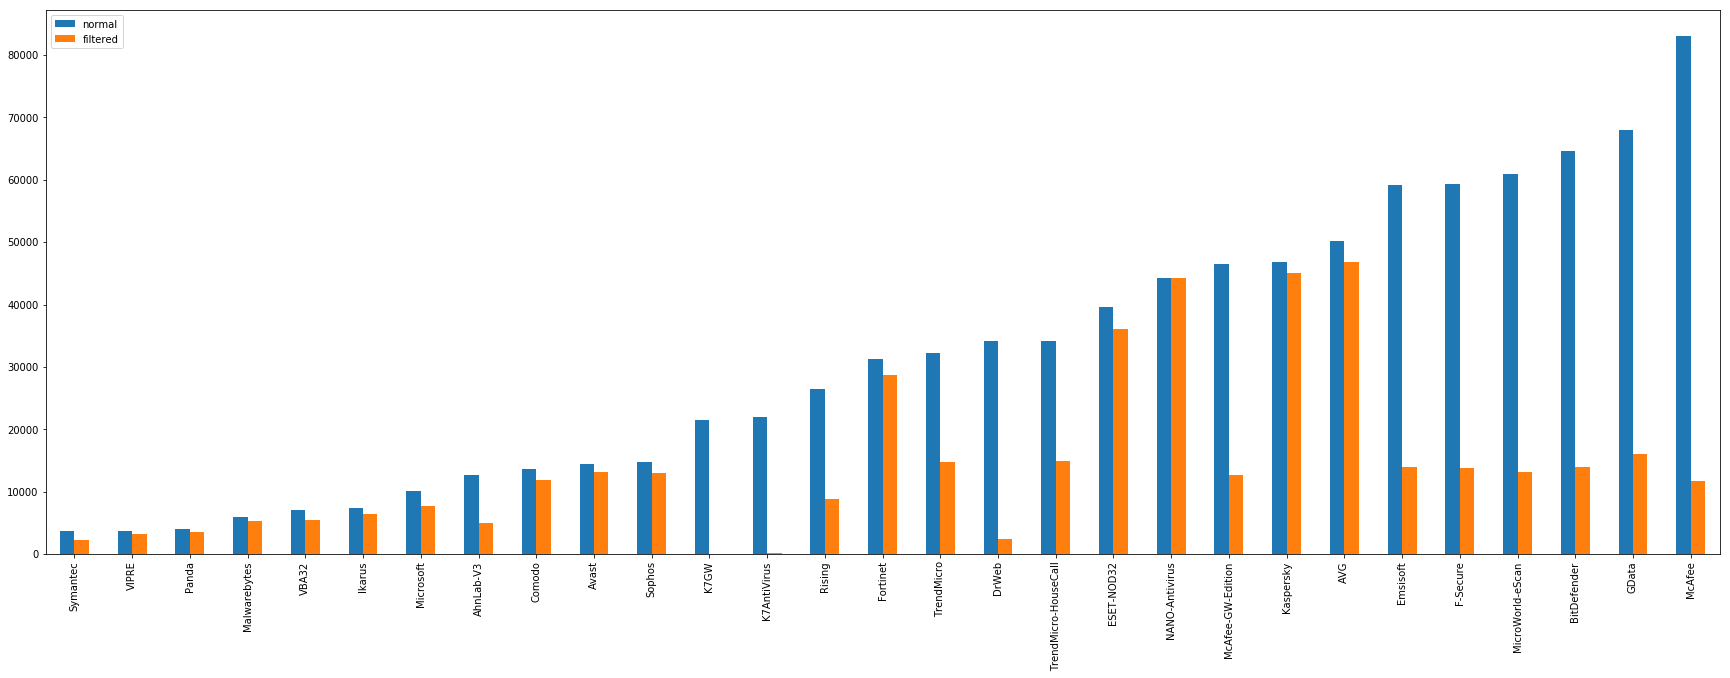

In [7]:
filtered_count = dict()
for vendor in filtered_names.keys():
    filtered_count[vendor] = len(filtered_names[vendor])
filtered_count = pd.Series(filtered_count)
filtered_count.sort_values().plot.bar(figsize=((30, 10)))

names_count_df = pd.DataFrame(names_count)
names_count_df[1] = filtered_count
names_count_df.columns = ['normal', 'filtered']
names_count_df.sort_values(by='normal').plot.bar(figsize=((30, 10)))
plt.show()

Apply the filter to the vendors DataFrame

In [8]:
def filter_func(name):
    # to_remove_list = set(['gen', 'generic', 'pe'])
    if name is np.nan:
        return np.nan
    name = regex.split(name)
    name = map(str.strip, map(str.lower, name))
    name = list(filter(lambda x: x != '' and len(x) > 1 and not regex2.search(x) and not regex3.search(x), name))
    # if len(name) > 1:
    #    name = [n for n in name if n not in to_remove_list]
    return '.'.join(name)

# vendors_filtered = vendors.applymap(filter_func)
# vendors_filtered.replace('', np.nan, inplace=True)
# vendors_filtered.to_csv(vendors_selected_filtered_file, compression='gzip')
vendors_filtered = pd.read_csv(vendors_selected_filtered_file, dtype='str')
vendors_filtered = vendors_filtered.set_index('link')

Build the name graph

In [9]:
# subset = vendors_filtered[:100000]
subset = vendors_filtered
subset.is_copy = False
# subset = subset[subset.count(axis=1) >= 5]
# display(subset)

# Replace names that are the same
malware = ['unwanted.program', 'ws.reputation', 'generic.malware', 'mal.generic', 'unclassifiedmalware',
           'malware.gen', 'artemis', 'heuristic.behaveslike.suspicious', 'heuristic.lookslike.suspicious',
           'uds.dangerousobject.multi.generic', 'heuristic.lookslike.suspiciouspe', 'heur', 'suspicious',
           'malware.generic', 'suspicious.file', 'malware.gen.generic', 'gen.malware.heur',
           'pe.malware.obscure.heur', 'generic.suspicious', 'mal.behav', 'generic', 'suspicious_gen',
           'application.generic', 'possiblethreat', 'agent']
trojan = ['troj_gen', 'trojan.gen', 'trj.genetic.gen', 'trojan.generic', 'trj.ci', 'pe.trojan.generic',
          'trojan.generickd', 'trojan.generic.bt', 'troj_spnr', 'generic.trojan', 'trojan.agent',
          'heur.trojan.generic', 'artemis.trojan', 'trojan.horse', 'trojware.trojan.agent.gen']
adware = ['adware.agent', 'adware.downware', 'pup.gen.pup', 'adware.generic', 'adware.gen.adw',
          'not.virus.adware']
worm = ['worm.generic', 'networm']
backdoor = ['backdoor.generic', 'backdoor.agent']

# subset.replace(malware, 'malware', inplace=True)
subset.replace(malware, np.nan, inplace=True)
subset.replace(trojan, 'trojan', inplace=True)
subset.replace(adware, 'adware', inplace=True)
subset.replace(worm, 'worm', inplace=True)
subset.replace(backdoor, 'backdoor', inplace=True)

In [10]:
%%time
edge_list = []

for l, s in subset.iterrows():
    s = s.dropna()
    s = map(sorted, itertools.combinations(s, 2))
    # filter_list = ['trojan', 'malware', 'virus', 'backdoor', 'adware', 'spyware', 'worm', 'riskware']
    filter_list = ['virus', 'worm', 'trojan']
    for a, b in s:
        # Remove some edges to facilitate manual analysis
        #if a in filter_list or b in filter_list:
        #    continue
        # if 'virus' in a or 'virus' in b:
        if a in filter_list or b in filter_list:
            edge_list.append({'a': a, 'b': b, 'weight':1.0})

frame_graph = pd.DataFrame(edge_list).groupby(['a', 'b']).sum().reset_index()

CPU times: user 2min 33s, sys: 1.13 s, total: 2min 34s
Wall time: 2min 34s


In [43]:
high_count_a = frame_graph['a'].value_counts()[:600].index
# high_count_a = high_count_a[high_count_a >= 100].index

high_count_b = frame_graph['b'].value_counts()[:600].index
# high_count_b = high_count_b[high_count_b >= 100].index

# frame_graph2 = frame_graph[frame_graph['a'].isin(high_count_a) | frame_graph['b'].isin(high_count_b)]
frame_graph2 = frame_graph[frame_graph['a'].isin(high_count_a) & frame_graph['b'].isin(high_count_b)]

In [44]:
# frame_graph2 = frame_graph
frame_graph2['len'] = 1 / frame_graph2['weight'] * 100
display(frame_graph2['weight'].describe())

/home/joao/virtual_envs/thesis2/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


count    3.111000e+03
mean     8.011896e+02
std      2.181733e+04
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      6.000000e+01
max      1.202393e+06
Name: weight, dtype: float64

In [45]:
frame_graph2 = frame_graph2[frame_graph2['weight'] >= 10]
display(frame_graph2['weight'].describe())

count    1.581000e+03
mean     1.573068e+03
std      3.058949e+04
min      1.000000e+01
25%      2.000000e+01
50%      5.700000e+01
75%      2.890000e+02
max      1.202393e+06
Name: weight, dtype: float64

In [68]:
%%time
G=nx.from_pandas_dataframe(frame_graph2, 'a', 'b', ['len'])
colors = range(len(G.edges()))[::-1]
pos = graphviz_layout(G, prog='twopi', args='-scale=1000')
# pos = graphviz_layout(G, prog='sfdp', args='-scale=100')

# plt.figure(figsize=(30, 50))
# A4 print size
plt.figure(figsize=(11.69, 8.27))
nx.draw_networkx(G, pos, font_size=5, node_size=1, edge_cmap=plt.cm.Blues, edge_color=colors, width=0.1)
plt.savefig('test.pdf', format='pdf', dpi=500)
plt.close()
# plt.show()

CPU times: user 2.67 s, sys: 1.19 s, total: 3.86 s
Wall time: 2.78 s
